# Install libraries

In [ ]:
!pip install -r requirements.txt

In [4]:
# https://github.com/teddysum/korean_ABSA_baseline/blob/0d47e3eef31419a2d31d859da2dfba4f9df75531/src/sentiment_analysis.py#L532-L630

def evaluation_f1(true_data, pred_data):

    true_data_list = true_data
    pred_data_list = pred_data

    ce_eval = {
        'TP': 0,
        'FP': 0,
        'FN': 0,
        'TN': 0
    }

    pipeline_eval = {
        'TP': 0,
        'FP': 0,
        'FN': 0,
        'TN': 0
    }

    for i in range(len(true_data_list)):

        # TP, FN checking
        is_ce_found = False
        is_pipeline_found = False
        for y_ano  in true_data_list[i]['annotation']:
            y_category = y_ano[0]
            y_polarity = y_ano[2]

            for p_ano in pred_data_list[i]['annotation']:
                p_category = p_ano[0]
                p_polarity = p_ano[1]

                if y_category == p_category:
                    is_ce_found = True
                    if y_polarity == p_polarity:
                        is_pipeline_found = True

                    break

            if is_ce_found is True:
                ce_eval['TP'] += 1
            else:
                ce_eval['FN'] += 1

            if is_pipeline_found is True:
                pipeline_eval['TP'] += 1
            else:
                pipeline_eval['FN'] += 1

            is_ce_found = False
            is_pipeline_found = False

        # FP checking
        for p_ano in pred_data_list[i]['annotation']:
            p_category = p_ano[0]
            p_polarity = p_ano[1]

            for y_ano  in true_data_list[i]['annotation']:
                y_category = y_ano[0]
                y_polarity = y_ano[2]

                if y_category == p_category:
                    is_ce_found = True
                    if y_polarity == p_polarity:
                        is_pipeline_found = True

                    break

            if is_ce_found is False:
                ce_eval['FP'] += 1

            if is_pipeline_found is False:
                pipeline_eval['FP'] += 1
            
            is_ce_found = False
            is_pipeline_found = False

    ce_precision = ce_eval['TP']/(ce_eval['TP']+ce_eval['FP'])
    ce_recall = ce_eval['TP']/(ce_eval['TP']+ce_eval['FN'])

    ce_result = {
        'Precision': ce_precision,
        'Recall': ce_recall,
        'F1': 2*ce_recall*ce_precision/(ce_recall+ce_precision)
    }

    pipeline_precision = pipeline_eval['TP']/(pipeline_eval['TP']+pipeline_eval['FP'])
    pipeline_recall = pipeline_eval['TP']/(pipeline_eval['TP']+pipeline_eval['FN'])

    pipeline_result = {
        'Precision': pipeline_precision,
        'Recall': pipeline_recall,
        'F1': 2*pipeline_recall*pipeline_precision/(pipeline_recall+pipeline_precision)
    }

    return {
        'category extraction result': ce_result,
        'entire pipeline result': pipeline_result
    }

# Load libraries

In [32]:
acd_save_path = './model/acd_best.bin'
asc_save_path = './model/asc_best.bin'
output_save_path = './output/submit.json'

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import os, sys
import re
import time
import json
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

import torch
import torch.nn.functional as F
from torch.utils.data import (
    TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
)
from transformers import (
    AdamW, get_linear_schedule_with_warmup,
    ElectraTokenizerFast, ElectraForSequenceClassification, ElectraForTokenClassification,
    BertTokenizerFast, BertForSequenceClassification
)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [8]:
# device = 'cpu'
device = 'cuda'
seed = 1235
batch_size = 4
learning_rate = 1e-5
warmup_proportion = 0.1
epochs = 10
warmup_steps = 1000
# max_len= 256

gradient_accumulation_steps = 4
num_train_epochs = epochs

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Load data

In [10]:
val = []
with open('data/nikluge-sa-2022-dev.jsonl', 'r') as file:
    for line in file.readlines():
        val.append(json.loads(line))
        

test = []
with open('data/nikluge-sa-2022-test.jsonl', 'r') as file:
    for line in file.readlines():
        test.append(json.loads(line))

In [11]:
entity_property_pair = [
    '본품#가격', '본품#다양성', '본품#디자인', '본품#인지도', '본품#일반', '본품#편의성', '본품#품질', 
    '브랜드#가격', '브랜드#디자인', '브랜드#인지도', '브랜드#일반', '브랜드#품질', 
    '제품 전체#가격', '제품 전체#다양성', '제품 전체#디자인', '제품 전체#인지도', '제품 전체#일반', '제품 전체#편의성', '제품 전체#품질', 
    '패키지/구성품#가격', '패키지/구성품#다양성', '패키지/구성품#디자인', '패키지/구성품#일반', '패키지/구성품#편의성', '패키지/구성품#품질'
]

entity_property_pair.sort()

entity_name_to_id = {entity_property_pair[i]: i for i in range( len(entity_property_pair) )}
entity_id_to_name = {v:k for k, v in entity_name_to_id.items()}

label_id_to_name = ['True', 'False']
label_name_to_id = {label_id_to_name[i]: i for i in range(len(label_id_to_name))}

polarity_id_to_name = ['positive', 'negative', 'neutral']
polarity_name_to_id = {polarity_id_to_name[i]: i for i in range(len(polarity_id_to_name))}

In [12]:
from copy import deepcopy
def convert(array: np.array, data: list):
    iter = array.shape[0]
    if iter != len(data):
        raise ValueError
    result = deepcopy(data)
    for i in range(iter):
        ind = np.where(array[i]==1)[0]
        result[i]['annotation'] = [[ entity_id_to_name[k], 'positive'] for k in ind]
    return result

# Set model

## ACD: electra

In [ ]:
tokenizer = ElectraTokenizerFast.from_pretrained("kykim/electra-kor-base")
model = ElectraForSequenceClassification.from_pretrained("kykim/electra-kor-base", num_labels = 1)

In [ ]:
state_dict = torch.load(acd_save_path, map_location = 'cpu')

model.load_state_dict(state_dict)
model.to(device)
print()

## ASC: electra

In [ ]:
model_asc = ElectraForSequenceClassification.from_pretrained("kykim/electra-kor-base", 
                                                             num_labels = len(polarity_id_to_name))

In [ ]:
state_dict = torch.load(asc_save_path, map_location = 'cpu')

model_asc.load_state_dict(state_dict)
model_asc.to(device)
print()

# data loader

## ACD

In [18]:
def get_devset(batch, train, max_len = 512):
    train_docs = [t['sentence_form'] for t in train]
    docs = [train_docs[b] for b in batch]
    train_batch = [train[b] for b in batch]

    result = []
    labels = []
    
    for idx, t in enumerate(train_batch):
        lab = torch.zeros(max_len, dtype=torch.long)
        cat_ids = [0] * len(entity_name_to_id)
        for a in t['annotation']:
            cat_ids[entity_name_to_id[a[0]]] = 1
        
        sents = [t['sentence_form']] * len(entity_name_to_id)
        cats = list(entity_name_to_id.keys())
        tokenized = tokenizer(sents, cats, padding='max_length', truncation=True, max_length=max_len)
        tokenized = [v for k, v in tokenized.items()]
        result.append(tokenized)
        labels.append(cat_ids)

    result = torch.tensor(result, dtype=torch.long).transpose(1,2)
    labels = torch.tensor(labels, dtype=torch.long)
    print(result.shape, labels.shape)
    return result, labels


In [19]:
# for devset
# 실행할 필요 없음

dev_range = torch.arange(len(val))
dev_ds = TensorDataset(*get_devset(dev_range, val))
dev_loader = DataLoader(dev_ds, sampler=SequentialSampler(dev_ds), batch_size=16)

torch.Size([2794, 25, 3, 512]) torch.Size([2794, 25])


In [20]:
# for testset

test_range = torch.arange(len(test))
test_ds = TensorDataset(*get_devset(test_range, test))
test_loader = DataLoader(test_ds, sampler=SequentialSampler(test_ds), batch_size=16)

torch.Size([2127, 25, 3, 512]) torch.Size([2127, 25])


# Inference

## ACD

#### val: 실행할 필요 없음

In [23]:
# logit_threshold = .2
# topk = 1

model.eval()
dev_pred = np.array([], dtype = np.float32).reshape(-1, len(entity_name_to_id))
dev_true = np.array([], dtype = np.int32).reshape(-1, len(entity_name_to_id))
dev_losses = []
# dev_step = 0

for batch in tqdm(dev_loader):
    inputs, labels = [b.to(device) for b in batch]
    
    inputs = inputs.reshape(-1, 3, 512)
    input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
    len_max = max(input_masks.sum(-1))
    input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

    with torch.no_grad():
        outputs = model(input_ids, input_masks, segment_ids)
        # b * num cats
        cls_logit = outputs['logits'].reshape(-1, len(entity_name_to_id))
        lab = labels.float() / labels.sum(1, keepdim = True)
        dev_losses.append(torch.nn.CrossEntropyLoss()(cls_logit, lab).item())
        
    true = labels.detach().cpu().numpy()
        
    # pred = (torch.nn.Softmax(-1)(cls_logit) > logit_threshold).int().detach().cpu().numpy()
    pred = cls_logit.detach().cpu().numpy()
    # if np.where(pred.sum(-1) == 0)[0].size == 0:
    #     pass
    # else:
    #     replaced_ind = np.where(pred.sum(-1) == 0)[0]
    #     replace = F.one_hot( torch.topk(cls_logit, topk, -1)[1], len(entity_name_to_id) ).sum(1).detach().cpu().numpy()
    #     pred[replaced_ind] = replace[replaced_ind]
    # pred = F.one_hot( torch.topk(cls_logit, 2, -1)[1], len(entity_name_to_id)//2 ).sum(1).detach().cpu().numpy()
    # pred = (F.one_hot(outputs['logits'].argmax(2), len(entity_name_to_id)+1).sum(1)).detach().cpu()
    # pred = (pred[:, 1::2] + pred[:, 2::2] > 0).int().numpy()

    dev_pred = np.vstack((dev_pred, pred))
    dev_true = np.vstack((dev_true, true))

100%|██████████| 175/175 [02:20<00:00,  1.25it/s]


In [24]:
threshold = np.linspace(0, 4, 1000)
res = []

for thr in tqdm(threshold):
    dev_pred_ = (dev_pred > thr).astype(np.int32)
    replaced_ind = np.where(dev_pred_.sum(-1) == 0)[0]
    argmax = dev_pred[replaced_ind].argsort(-1)[:, -1:]

    zeros = np.zeros((replaced_ind.size, len(entity_id_to_name)))
    zeros[np.arange(argmax.shape[0]).reshape(-1, 1), argmax] = 1

    dev_pred_[replaced_ind] = zeros
    res.append(evaluation_f1(val, convert(dev_pred_, val))['category extraction result']['F1'])


100%|██████████| 1000/1000 [01:02<00:00, 15.97it/s]


In [29]:
threshold[(np.array(res)).argmax()], res[(np.array(res)).argmax()]

(3.3633633633633635, 0.7369770796602019)

In [36]:
best_logit_threshold = 3.3633633633633635

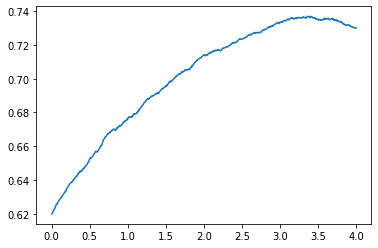

In [30]:
plt.plot(threshold, res)
plt.show()

### inference

In [21]:
# electra

# logit_threshold = .2
# topk = 1

proba_thre = False

model.eval()
if proba_thre:
    test_pred = np.array([], dtype = np.int32).reshape(-1, len(entity_name_to_id))
else:
    test_pred = np.array([], dtype = np.float32).reshape(-1, len(entity_name_to_id))

for batch in tqdm(test_loader):
    inputs, _ = [b.to(device) for b in batch]
    
    inputs = inputs.reshape(-1, 3, 512)
    input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
    len_max = max(input_masks.sum(-1))
    input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

    with torch.no_grad():
        outputs = model(input_ids, input_masks, segment_ids)
        # b * num cats
        cls_logit = outputs['logits'].reshape(-1, len(entity_name_to_id))
        # lab = labels.float() / labels.sum(1, keepdim = True)
        # dev_losses.append(torch.nn.CrossEntropyLoss()(cls_logit, lab).item())
        # true = labels.detach().cpu().numpy()
            
    if proba_thre:
        pred = (torch.nn.Softmax(-1)(cls_logit) > logit_threshold).int().detach().cpu().numpy()
        if np.where(pred.sum(-1) == 0)[0].size == 0:
            pass
        else:
            replaced_ind = np.where(pred.sum(-1) == 0)[0]
            replace = F.one_hot( torch.topk(cls_logit, topk, -1)[1], len(entity_name_to_id) ).sum(1).detach().cpu().numpy()
            pred[replaced_ind] = replace[replaced_ind]

        test_pred = np.vstack((test_pred, pred))
    else:
        pred = cls_logit.detach().cpu().numpy()
        test_pred = np.vstack((test_pred, pred))
    # pred = F.one_hot( torch.topk(cls_logit, 2, -1)[1], len(entity_name_to_id)//2 ).sum(1).detach().cpu().numpy()
    # pred = (F.one_hot(outputs['logits'].argmax(2), len(entity_name_to_id)+1).sum(1)).detach().cpu()
    # pred = (pred[:, 1::2] + pred[:, 2::2] > 0).int().numpy()

100%|██████████| 133/133 [02:18<00:00,  1.04s/it]


In [37]:
print(best_logit_threshold)

3.3633633633633635


In [38]:
lth = best_logit_threshold
test_pred_ = (test_pred > lth).astype(np.int32)
# print(np.unique(test_pred_.sum(-1), return_counts = True))

replaced_ind = np.where(test_pred_.sum(-1) == 0)[0]
argmax = test_pred[replaced_ind].argmax(-1)

replace = np.zeros((replaced_ind.size, len(entity_id_to_name)))
replace[np.arange(argmax.size), argmax] = 1

test_pred_[replaced_ind] = replace
test_result = convert(test_pred_, test)

## ASC

In [40]:
def get_testset(batch, train, max_len = 512):
    train_docs = [t['sentence_form'] for t in train]
    docs = [train_docs[b] for b in batch]
    train_batch = [train[b] for b in batch]

    result = torch.LongTensor([]).reshape(-1, 3, max_len)
    labels = []
    
    for idx, t in enumerate(train_batch):
        polar = []
        entity = []
        for a in t['annotation']:
            entity.append(a[0])
            polar.append(a[1])
        
        sents = [t['sentence_form']] * len(entity)
        tokenized = tokenizer(sents, entity, padding='max_length', truncation=True, max_length=max_len)
        tokenized = torch.LongTensor([v for k, v in tokenized.items()]).transpose(0, 1 )
        result = torch.vstack((result, tokenized))
        labels += [ polarity_name_to_id[p] for p in polar]

    labels = torch.tensor(labels, dtype=torch.long)
    return result, labels

In [41]:
batch_size = 1
test_range_asc = torch.arange(len(test))
test_ds_asc = TensorDataset(test_range_asc)
test_loader_asc = DataLoader(test_ds_asc, sampler=SequentialSampler(test_ds_asc), batch_size=batch_size)

In [42]:
model_asc.eval()
test_pred_ids = np.array([])

for batch in tqdm(test_loader_asc):
    inputs, _ = get_testset(batch[0], test_result, )
    inputs = inputs.to(device)
    
    input_ids, input_segment, input_masks = inputs[:,0], inputs[:,1], inputs[:,2]
    len_max = max(input_masks.sum(-1))
    input_ids, input_masks, segment_ids = input_ids[:,:len_max], input_masks[:,:len_max], input_segment[:,:len_max]

    with torch.no_grad():
        outputs = model_asc(input_ids, input_masks, segment_ids)
        # b * num cats
        cls_logit = outputs['logits']
        # dev_losses.append(torch.nn.CrossEntropyLoss()(cls_logit, labels).item())
        
        # true = labels.unsqueeze(0).detach().cpu().numpy()
            
        pred = cls_logit.argmax(1).detach().cpu().numpy()
        # pred = F.one_hot( torch.topk(cls_logit, 2, -1)[1], len(entity_name_to_id)//2 ).sum(1).detach().cpu().numpy()
        # pred = (F.one_hot(outputs['logits'].argmax(2), len(entity_name_to_id)+1).sum(1)).detach().cpu()
        # pred = (pred[:, 1::2] + pred[:, 2::2] > 0).int().numpy()
    test_pred_ids = np.append(test_pred_ids, pred)
    for ip, pp in enumerate(pred):
        test_result[batch[0].item()]['annotation'][ip][-1] = polarity_id_to_name[pp]

100%|██████████| 2127/2127 [00:49<00:00, 43.31it/s]


# Submission

In [30]:
os.makedirs('output', exist_ok=True)

In [34]:
with open(output_save_path, 'w', encoding = 'utf-8') as f:
    for i in test_result:
        f.write(json.dumps(i, ensure_ascii=False) + '\n')